In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/cp640')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [ ]:
sys.path.append('/content/drive/MyDrive/cp640')
data = pd.read_csv('/content/drive/MyDrive/cp640/Historical Product Demand 2.csv',sep=',', encoding='utf-8')
print("\nSummary of DataFrame:")
print(data.info())


Summary of DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB
None


In [ ]:
explo_df=data.copy()
warehouse_mapping = {
    'Whse_J': 0,
    'Whse_A': 1,
    'Whse_S': 2,
    'Whse_C': 3
}

explo_df['Warehouse'] = explo_df['Warehouse'].map(warehouse_mapping).fillna(4)
explo_df['Product_Category'] = explo_df['Product_Category'].str.extract('(\d+)').astype(int)
explo_df['Product_Code'] = explo_df['Product_Code'].str.extract('(\d+)').astype(int)
explo_df['Date'] = pd.to_datetime(explo_df['Date'])
print(explo_df.head())

   Product_Code  Warehouse  Product_Category       Date Order_Demand
0           993          0                28 2012-07-27         100 
1           979          0                28 2012-01-19         500 
2           979          0                28 2012-02-03         500 
3           979          0                28 2012-02-09         500 
4           979          0                28 2012-03-02         500 


In [ ]:
explo_df['Order_Demand'] = pd.to_numeric(explo_df['Order_Demand'], errors='coerce')
explo_df = explo_df.dropna(subset=['Order_Demand'])
print(explo_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1038106 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1038106 non-null  int64         
 1   Warehouse         1038106 non-null  int64         
 2   Product_Category  1038106 non-null  int64         
 3   Date              1031437 non-null  datetime64[ns]
 4   Order_Demand      1038106 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 47.5 MB
None


In [ ]:
correlation_matrix = explo_df.corr()

# Extract correlations with the target var
correlation_with_target = correlation_matrix['Order_Demand']

# Print correlations
print("Correlation with Order_Demand:")
print(correlation_with_target)

Correlation with Order_Demand:
Product_Code        0.031579
Warehouse           0.071759
Product_Category    0.053749
Date                0.011754
Order_Demand        1.000000
Name: Order_Demand, dtype: float64


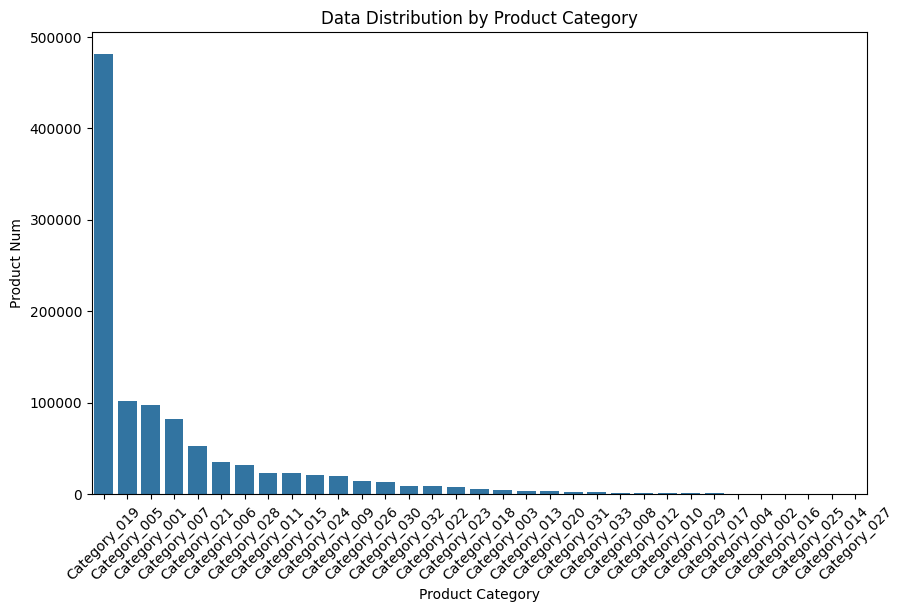

In [ ]:
category_distribution = data['Product_Category'].value_counts()

# view the data distribution
plt.figure(figsize=(10,6))
sns.barplot(x=category_distribution.index, y=category_distribution.values)
plt.xlabel('Product Category')
plt.ylabel('Product Num')
plt.title('Data Distribution by Product Category')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("category name: {}".format(category_distribution.index[0]))
print("product num of category: {}".format(category_distribution.values[0]))

category name: Category_019
product num of category: 481099


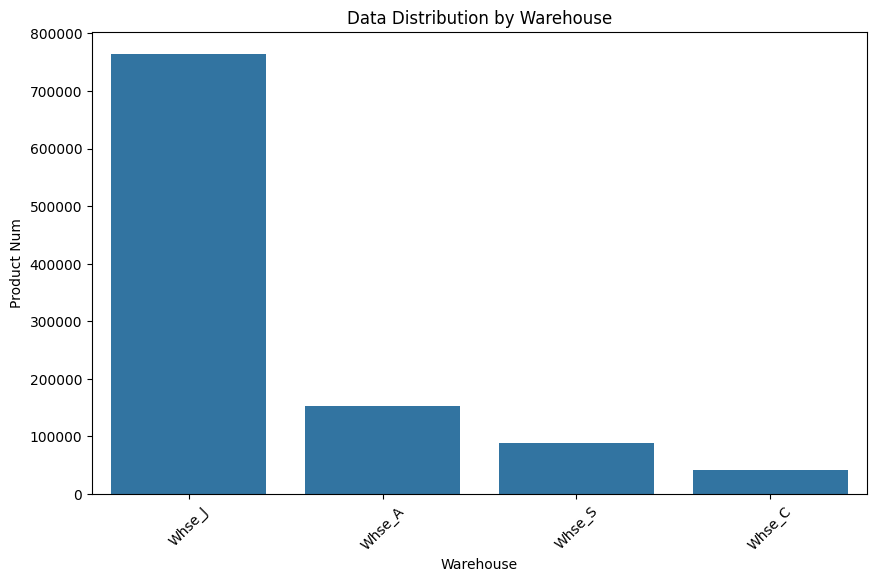

In [ ]:
warehouse_distribution = data['Warehouse'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=warehouse_distribution.index, y=warehouse_distribution.values)
plt.xlabel('Warehouse')
plt.ylabel('Product Num')
plt.title('Data Distribution by Warehouse')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("warehouse name: {}".format(warehouse_distribution.index[0]))
print("product num of warehouse: {}".format(warehouse_distribution.values[0]))

warehouse name: Whse_J
product num of warehouse: 764447


In [ ]:
category = category_distribution.index[0]
warehouse = warehouse_distribution.index[0]
df_category = data[(data['Product_Category'] == category) & (data['Warehouse'] == warehouse)]
print(df_category.head())

    Product_Code Warehouse Product_Category       Date Order_Demand
63  Product_1234    Whse_J     Category_019  2012/4/25        1000 
64  Product_1451    Whse_J     Category_019  2012/1/12        1000 
65  Product_1274    Whse_J     Category_019  2012/1/16        1000 
66  Product_1274    Whse_J     Category_019  2012/1/24        1000 
67  Product_1274    Whse_J     Category_019  2012/1/24        1000 


In [ ]:
warehouse_mapping = {
    'Whse_J': 0,
    'Whse_A': 1,
    'Whse_S': 2,
    'Whse_C': 3
}

df_category['Warehouse'] = df_category['Warehouse'].map(warehouse_mapping).fillna(4)
df_category['Product_Category'] = df_category['Product_Category'].str.extract('(\d+)').astype(int)
df_category['Product_Code'] = df_category['Product_Code'].str.extract('(\d+)').astype(int)
df_category['Date'] = pd.to_datetime(df_category['Date'])
df_category['Order_Demand'] = pd.to_numeric(df_category['Order_Demand'], errors='coerce')
df_category = df_category.dropna(subset=['Order_Demand'])
df_category['Order_Demand'] = df_category['Order_Demand'].astype(int)
print(df_category.info())

<ipython-input-12-da952a3f08c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['Warehouse'] = df_category['Warehouse'].map(warehouse_mapping).fillna(4)
<ipython-input-12-da952a3f08c8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['Product_Category'] = df_category['Product_Category'].str.extract('(\d+)').astype(int)
<ipython-input-12-da952a3f08c8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

<class 'pandas.core.frame.DataFrame'>
Index: 367904 entries, 63 to 1048539
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      367904 non-null  int64         
 1   Warehouse         367904 non-null  int64         
 2   Product_Category  367904 non-null  int64         
 3   Date              367904 non-null  datetime64[ns]
 4   Order_Demand      367904 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 16.8 MB
None


<ipython-input-12-da952a3f08c8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['Order_Demand'] = pd.to_numeric(df_category['Order_Demand'], errors='coerce')
<ipython-input-12-da952a3f08c8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['Order_Demand'] = df_category['Order_Demand'].astype(int)


In [ ]:
print(df_category.head())

    Product_Code  Warehouse  Product_Category       Date  Order_Demand
63          1234          0                19 2012-04-25          1000
64          1451          0                19 2012-01-12          1000
65          1274          0                19 2012-01-16          1000
66          1274          0                19 2012-01-24          1000
67          1274          0                19 2012-01-24          1000


In [ ]:
# feature engineering
daily_demand_df = df_category.groupby(['Date']).agg(Daily_Demand=('Order_Demand', 'sum')).reset_index()
print(daily_demand_df.head())

        Date  Daily_Demand
0 2011-12-15          1000
1 2011-12-21           800
2 2011-12-26          5500
3 2011-12-27         13200
4 2011-12-28         10000


In [ ]:
demand_range = daily_demand_df['Daily_Demand'].max() - daily_demand_df['Daily_Demand'].min()
print("Range of Demand: from {} to {}:".format(daily_demand_df['Daily_Demand'].max(), daily_demand_df['Daily_Demand'].min()))

Range of Demand: from 5423135 to 0:


In [ ]:
p_model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.06, n_changepoints=30, changepoint_range=0.85, interval_width=0.85, uncertainty_samples=1000)
# p_model.add_seasonality(name='weekly_pre_fx', period=7, fourier_order=3)
p_model.add_seasonality(name='monthly_pre_fx', period=30, fourier_order=4)
p_model.add_seasonality(name='quarterly_pre_fx', period=91.25, fourier_order=5)
prophet_data = daily_demand_df.rename(columns={'Daily_Demand': 'y', 'Date' : 'ds'})
prophet_data = prophet_data.reindex(columns=['ds', 'y'] + [col for col in prophet_data.columns if col not in ['ds', 'y']])
scaler = MinMaxScaler()
prophet_data['y_scaled'] = scaler.fit_transform(prophet_data[['y']])
prophet_data_sorted = prophet_data.sort_values(by='ds', ascending=True)
train_size = int(0.7 * len(prophet_data))

prophet_data_train = prophet_data_sorted.iloc[:train_size][['ds', 'y_scaled']]
prophet_data_train = prophet_data_train.rename(columns={'y_scaled': 'y'})

prophet_data_val = prophet_data_sorted.iloc[train_size:][['ds', 'y_scaled']]
prophet_data_val = prophet_data_val.rename(columns={'y_scaled': 'y'})
p_model.fit(prophet_data_train)
future = p_model.make_future_dataframe(periods=365, freq="D")
prophet_forecast = p_model.predict(future)
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
# prophet_forecast = prophet_forecast[prophet_forecast['ds'].isin(prophet_data_val['ds'])]
merged_result = pd.merge(prophet_data_val[['ds', 'y']], prophet_forecast[['ds', 'yhat']], on='ds', how='inner')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/g6nv5phg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/r6wk73x0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23328', 'data', 'file=/tmp/tmp8ow_u28a/g6nv5phg.json', 'init=/tmp/tmp8ow_u28a/r6wk73x0.json', 'output', 'file=/tmp/tmp8ow_u28a/prophet_modelciq_o2vn/prophet_model-20241102234130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
print(len(merged_result))

255


In [ ]:
prophet_models = {}
prophet_merged_results = {}
prophet_forecasts = {}
prophet_residuals = {}

prophet_models[category] = p_model
prophet_merged_results[category] = merged_result
prophet_forecasts[category] = prophet_forecast
actual_demand = merged_result['y']
prophet_predicts = merged_result['yhat']
prophet_residuals[category] = [actual - predict for actual, predict in zip(actual_demand, prophet_predicts)]

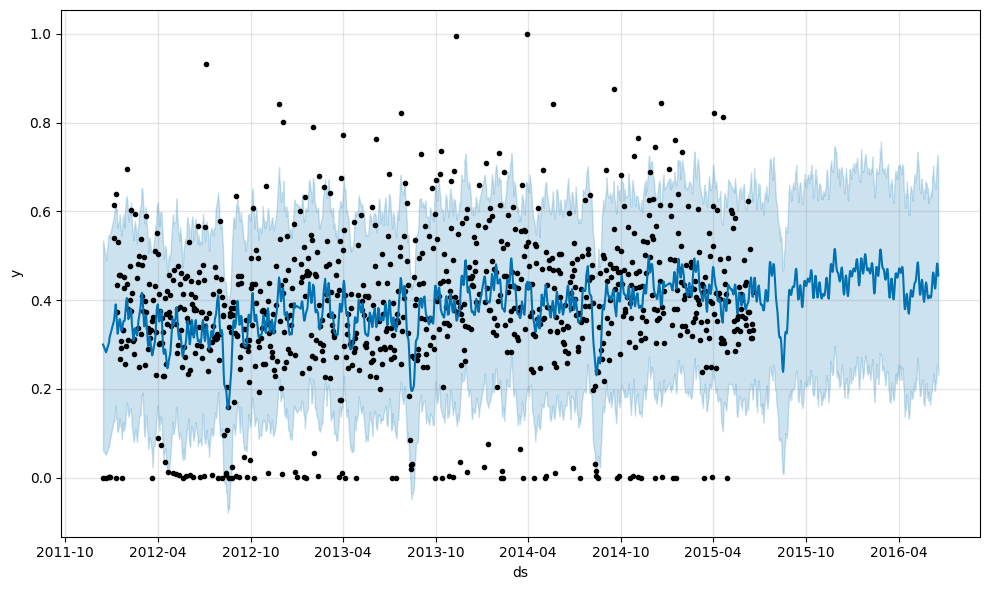

In [ ]:
fig_o = p_model.plot(prophet_forecast)

In [ ]:
plot_components_plotly(p_model, prophet_forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [ ]:
prophet_forecast.tail(14)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly_pre_fx,...,quarterly_pre_fx,quarterly_pre_fx_lower,quarterly_pre_fx_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1274,2016-06-05,0.442688,0.192396,0.633942,0.440808,0.444393,-0.023802,-0.023802,-0.023802,-0.004590,...,-0.028263,-0.028263,-0.028263,0.009051,0.009051,0.009051,0.0,0.0,0.0,0.418886
1275,2016-06-06,0.442746,0.200581,0.674434,0.440861,0.444459,-0.006085,-0.006085,-0.006085,0.011489,...,-0.032708,-0.032708,-0.032708,0.015134,0.015134,0.015134,0.0,0.0,0.0,0.436662
1276,2016-06-07,0.442805,0.215227,0.684947,0.440915,0.444525,0.011121,0.011121,0.011121,0.026253,...,-0.036275,-0.036275,-0.036275,0.021143,0.021143,0.021143,0.0,0.0,0.0,0.453925
1277,2016-06-08,0.442863,0.236435,0.703058,0.440969,0.444589,0.019489,0.019489,0.019489,0.031528,...,-0.038953,-0.038953,-0.038953,0.026913,0.026913,0.026913,0.0,0.0,0.0,0.462351
1278,2016-06-09,0.442921,0.221348,0.673860,0.441022,0.444654,0.015007,0.015007,0.015007,0.023535,...,-0.040808,-0.040808,-0.040808,0.032281,0.032281,0.032281,0.0,0.0,0.0,0.457928
1279,2016-06-10,0.442979,0.217336,0.664500,0.441076,0.444718,0.001101,0.001101,0.001101,0.005977,...,-0.041961,-0.041961,-0.041961,0.037086,0.037086,0.037086,0.0,0.0,0.0,0.444081
1280,2016-06-11,0.443038,0.195355,0.662225,0.441129,0.444783,-0.012862,-0.012862,-0.012862,-0.011477,...,-0.042564,-0.042564,-0.042564,0.041179,0.041179,0.041179,0.0,0.0,0.0,0.430176
1281,2016-06-12,0.443096,0.198012,0.651807,0.441180,0.444848,-0.017025,-0.017025,-0.017025,-0.018682,...,-0.042766,-0.042766,-0.042766,0.044423,0.044423,0.044423,0.0,0.0,0.0,0.426071
1282,2016-06-13,0.443154,0.221457,0.657933,0.441232,0.444912,-0.007149,-0.007149,-0.007149,-0.011159,...,-0.042689,-0.042689,-0.042689,0.046699,0.046699,0.046699,0.0,0.0,0.0,0.436006
1283,2016-06-14,0.443213,0.212577,0.688459,0.441285,0.444977,0.012501,0.012501,0.012501,0.006994,...,-0.042403,-0.042403,-0.042403,0.047910,0.047910,0.047910,0.0,0.0,0.0,0.455714


In [ ]:
df_cv = cross_validation(p_model, initial='730 days', period='180 days', horizon='365 days')
df_perf_metrics = performance_metrics(df_cv)
print(df_perf_metrics.head())

INFO:prophet:Making 2 forecasts with cutoffs between 2013-12-21 00:00:00 and 2014-06-19 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/gke29rdj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/a6t1_cos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26521', 'data', 'file=/tmp/tmp8ow_u28a/gke29rdj.json', 'init=/tmp/tmp8ow_u28a/a6t1_cos.json', 'output', 'file=/tmp/tmp8ow_u28a/prophet_modelz6gq43nq/prophet_model-20241102234150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/nxaoo3js.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ow_u28a/6inleyqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon       mse      rmse       mae     mdape     smape  coverage
0 40 days  0.025383  0.159321  0.113163  0.182974  0.320338  0.865385
1 41 days  0.024127  0.155328  0.107690  0.164308  0.309336  0.865385
2 42 days  0.024103  0.155252  0.107428  0.164308  0.308657  0.865385
3 43 days  0.025046  0.158259  0.110861  0.182974  0.314650  0.846154
4 44 days  0.025342  0.159192  0.112614  0.182974  0.316640  0.836538


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



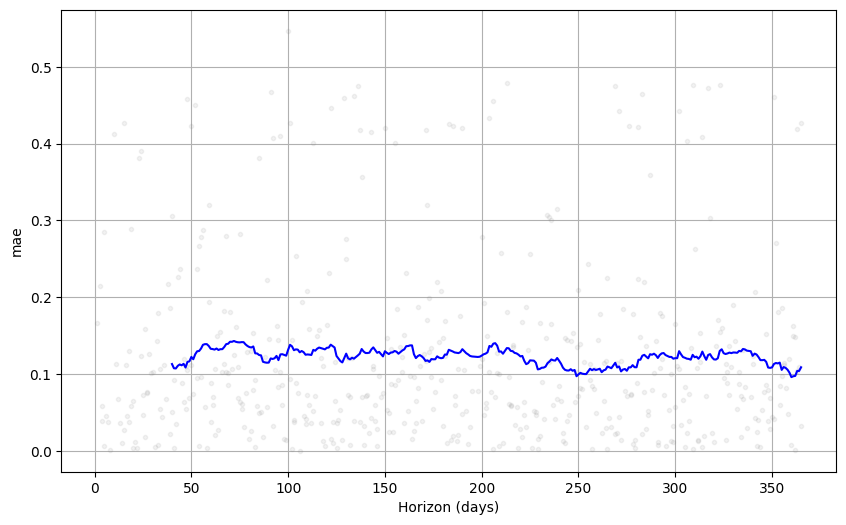

In [ ]:
fig_obj = plot_cross_validation_metric(df_cv, metric='mae')

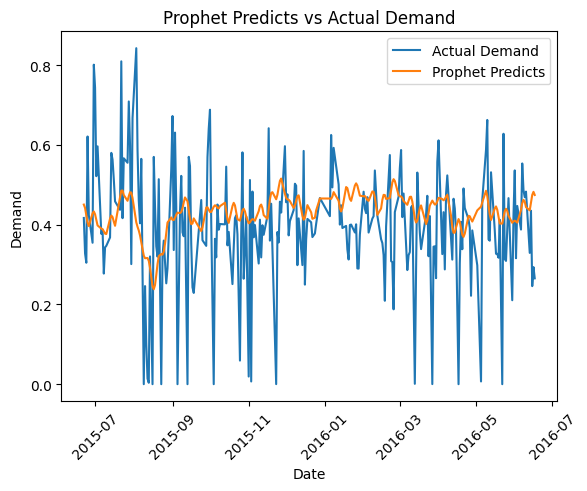

In [ ]:
plt.plot(prophet_merged_results[category]['ds'], prophet_merged_results[category]['y'], label='Actual Demand')
plt.plot(prophet_merged_results[category]['ds'], prophet_merged_results[category]['yhat'], label='Prophet Predicts')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Prophet Predicts vs Actual Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

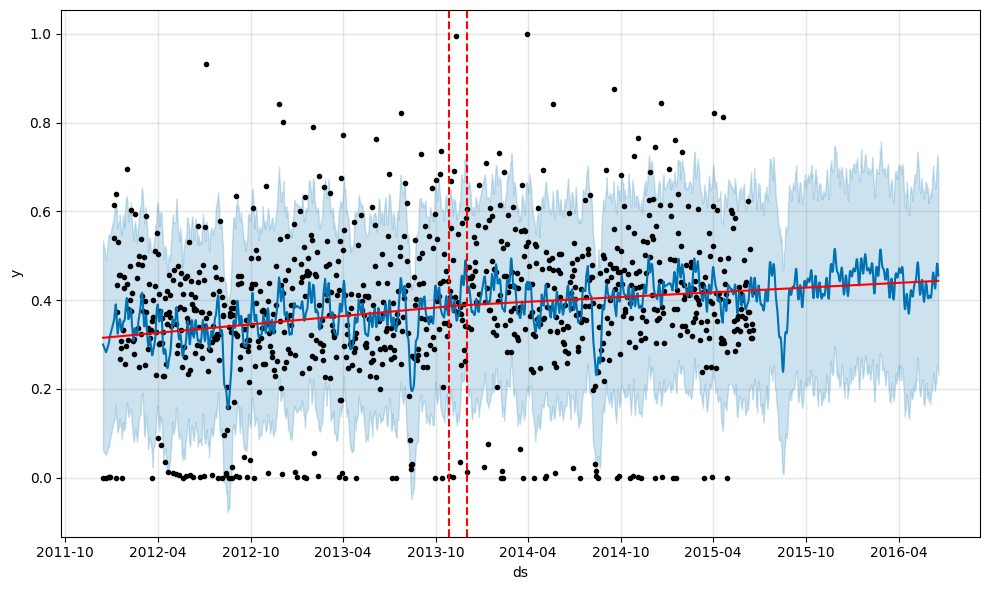

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig_cp = p_model.plot(prophet_forecast)
a = add_changepoints_to_plot(fig_cp.gca(), p_model, prophet_forecast)

In [ ]:
print(len(prophet_residuals[category]))
print(prophet_residuals[category])

255
[-0.03357358315475201, -0.11414157205200232, -0.11882470069658052, 0.2162249644077745, 0.02772523810691091, -0.07385963585032268, 0.36824111035179935, 0.31762718055407063, 0.10962807498244437, 0.19829456800218387, -0.012936872587215986, -0.0011346820791763856, -0.10610411063941727, -0.03442946447817963, -0.029636182155202695, -0.047199468426404545, 0.15716406216229817, 0.1439705948864245, 0.10639024384235118, 0.061222587612055734, -0.03178975350312907, 0.3243344547848444, -0.06942187807748323, 0.09219570492007917, 0.09540194599821694, 0.23724665482414287, 0.11725952714041277, -0.17932956431476132, 0.20085617522385557, 0.43690718911672377, 0.1921279369335463, 0.07493570850038783, 0.03052953240726175, 0.20941039179229748, -0.3223655769973574, -0.0698551275427795, -0.21533710549932678, -0.30251154357373233, -0.30576648754912783, 0.02899578387944396, -0.24561652573846185, 0.33197318208931903, 0.1966620937411796, 0.07233853891567138, 0.018666447609924086, 0.19284970904446336, -0.3265421

In [ ]:
# verify if TensorFlow will utilize the GPU for the model training
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [ ]:
# prepare for LSTM input sequence
def prepare_sequences(residual_data, sequence_length, p_name):
    """
    Inputs:
    residual data: a list contains the residual data calculated from the previous prophet model forecasting.
    sequence_length: num of steps to look back (how many past data points the LSTM will consider as input for its prediction)
    add_reg: additive regressors added to the residual data
    p_name: name of the prophet model

    Returns:
        tuple: A tuple containing three elements:
            - forecast_data (pandas.DataFrame): A DataFrame with the original data
                                                 merged with the forecast results.
            - model (Prophet): The fitted Prophet model object.
            - forecast (pandas.DataFrame): The raw forecast DataFrame generated by Prophet.
    """
    X = []
    y = []
    if len(residual_data) < sequence_length:
        print("Product Type: ",p_name)
        print("length of residual data: ",len(residual_data))
        print("sequence length: ",sequence_length)
        raise Exception("len(residual_data) must be greater than sequence_length")
    for i in range(len(residual_data) - sequence_length):
        X.append(residual_data[i:i+sequence_length])
        y.append(residual_data[i+sequence_length])
    return np.array(X), np.array(y)

# LSTM model architecture
def create_lstm_model(n_steps, n_features):
    """
    Inputs:
            - n_steps: how many past data points the LSTM will consider as input for its prediction
            - n_features: number of features in the input sequence

    Returns:
            - model (LSTM): The fitted LSTM model instance
    """
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=32, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.02)))
    # dropout or L2 regularization to help prevent the model from memorizing the training data
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=32, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.02)))
    lstm_model.add(Dropout(0.1))
    lstm_model.add(LSTM(units=16, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)))
    lstm_model.add(Dropout(0.1))
    lstm_model.add(LSTM(units=16, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)))
    lstm_model.add(Dropout(0.1))
    lstm_model.add(Dense(units=1))
    # Mean Squared Error: measure of overall forecasting error
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return lstm_model

In [ ]:
# num of steps to look back
n_steps = 120
# num of features
n_features = 1
# num of training epochs
n_epochs = 90

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0, restore_best_weights=True)

lstm_models = {}
refined_forecasts = {}

residual = prophet_residuals[category]
scaler = MinMaxScaler(feature_range=(0, 1))
residual_scaled = scaler.fit_transform(np.array(residual).reshape(-1, 1))
X_train, y_train = prepare_sequences(residual_scaled, n_steps, category)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# Create and compile LSTM model
lstm_model = create_lstm_model(n_steps, n_features)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, train_size=0.7, random_state=42)

model_path = f'{category}_model.keras'
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=0)

# Train LSTM model
lstm_model.fit(X_train, y_train,
                epochs=n_epochs,
                batch_size=128,
                validation_data=(X_val, y_val),
                verbose=0,
                callbacks=[model_checkpoint, early_stopping])

val_loss_train, train_mae, train_mse = lstm_model.evaluate(X_train, y_train)
print("training Loss: ", val_loss_train)
print("training Mean Absolute Error:", train_mae)
print("training Mean Squared Error:", train_mse)
val_loss_test, test_mae, test_mse = lstm_model.evaluate(X_val, y_val)
print("Validation Loss: ", val_loss_test)
print("Validation Mean Absolute Error:", test_mae)
print("Validation Mean Squared Error:", test_mse)

lstm_models[category] = lstm_model

future_residuals = []

last_residuals = np.array(residual_scaled[-n_steps:]).reshape((1, n_steps, n_features))
for i in range(len(prophet_forecasts[category])):
    # Predict next residual using the LSTM model
    next_residual = lstm_model.predict(last_residuals)[0, 0]
    future_residuals.append(next_residual)

    # Update 'last_residuals' by removing the first element and appending the predicted residual
    last_residuals = np.roll(last_residuals, -1, axis=1)
    last_residuals[0, -1, 0] = next_residual

# enhance forecasting results by adding residuals
refined_forecast = np.array(prophet_forecasts[category]['yhat']) + np.array(future_residuals)
refined_forecasts[category] = refined_forecast

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5025 - mae: 0.1230 - mse: 0.0268
training Loss:  0.5032539367675781
training Mean Absolute Error: 0.12387057393789291
training Mean Squared Error: 0.027538234367966652
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4973 - mae: 0.1097 - mse: 0.0216
Validation Loss:  0.497042715549469
Validation Mean Absolute Error: 0.10953345894813538
Validation Mean Squared Error: 0.02132704108953476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<ipython-input-28-ed14c4c63e72>:56: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

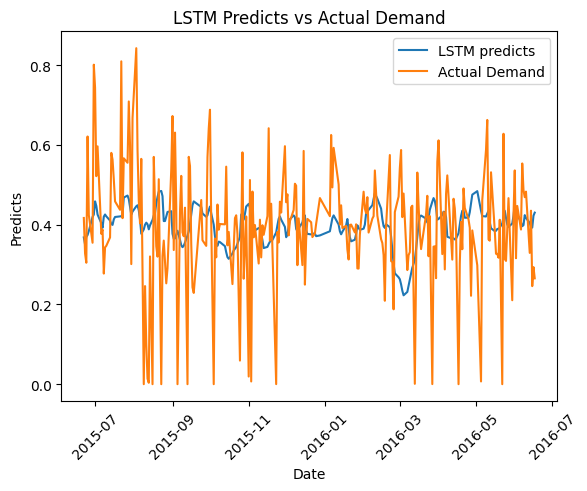

In [ ]:
len_p = len(prophet_merged_results[category])
common_index =prophet_merged_results[category]['ds']

# Adjust lengths of LSTM predictions to match the lengths of Prophet residuals
refined_predict = pd.Series(refined_forecasts[category][0][:len_p])
plt.plot(common_index, refined_predict, label='LSTM predicts')
plt.plot(prophet_merged_results[category]['ds'], prophet_merged_results[category]['y'], label='Actual Demand')
plt.xlabel('Date')
plt.ylabel('Predicts')
plt.title('LSTM Predicts vs Actual Demand')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

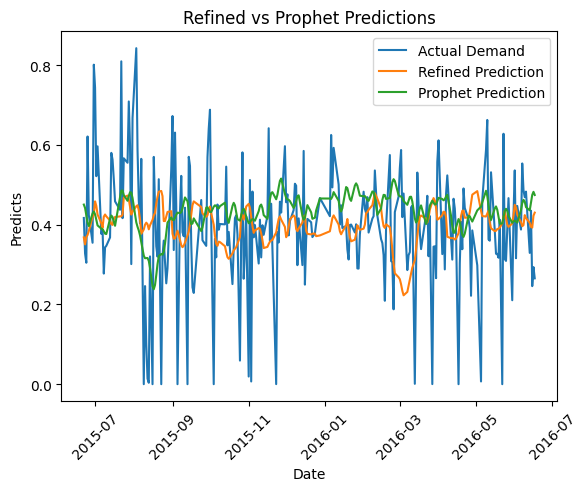

In [ ]:
# Adjust lengths of LSTM predictions to match the lengths of Prophet residuals
refined_predict = pd.Series(refined_forecasts[category][0][:len_p])

# Plot residuals against the 'ds' column
# plt.plot(common_index, prophet_merged_results[products[1]]['y'], label='Actual demand')
plt.plot(common_index, prophet_merged_results[category]['y'], label='Actual Demand')
plt.plot(common_index, refined_predict, label='Refined Prediction')
plt.plot(common_index, prophet_merged_results[category]['yhat'], label='Prophet Prediction')
plt.xlabel('Date')
plt.ylabel('Predicts')
plt.title('Refined vs Prophet Predictions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

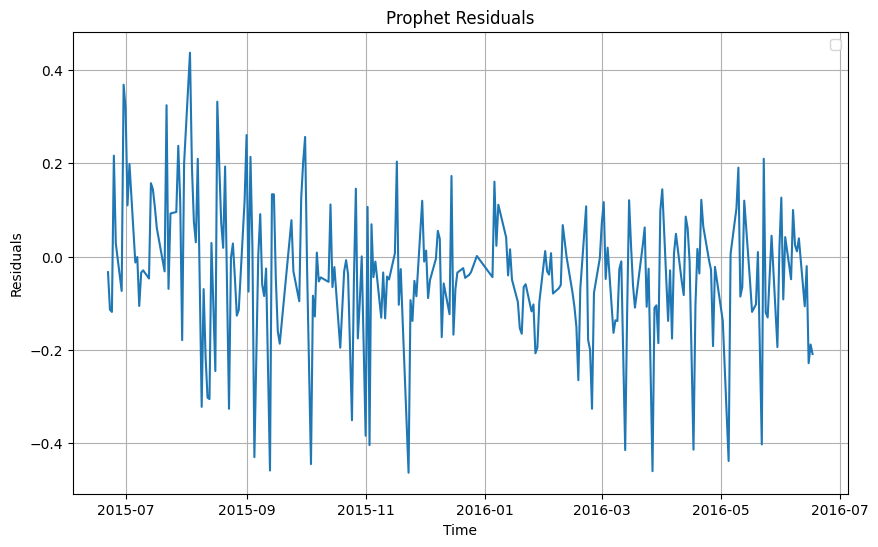

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results[category]['ds'], prophet_residuals[category])
plt.title('Prophet Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

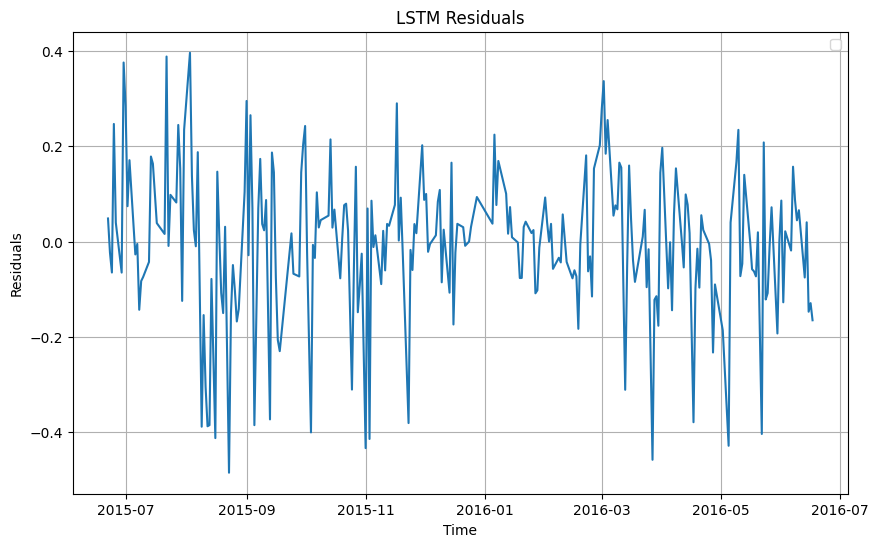

In [ ]:
LSTM_residuals = {}
actual_prices = prophet_merged_results[category]['y']
LSTM_residuals[category] = [actual - predict for actual, predict in zip(actual_prices, refined_forecasts[category][0][:len_p])]
# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results[category]['ds'], LSTM_residuals[category])
plt.title('LSTM Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

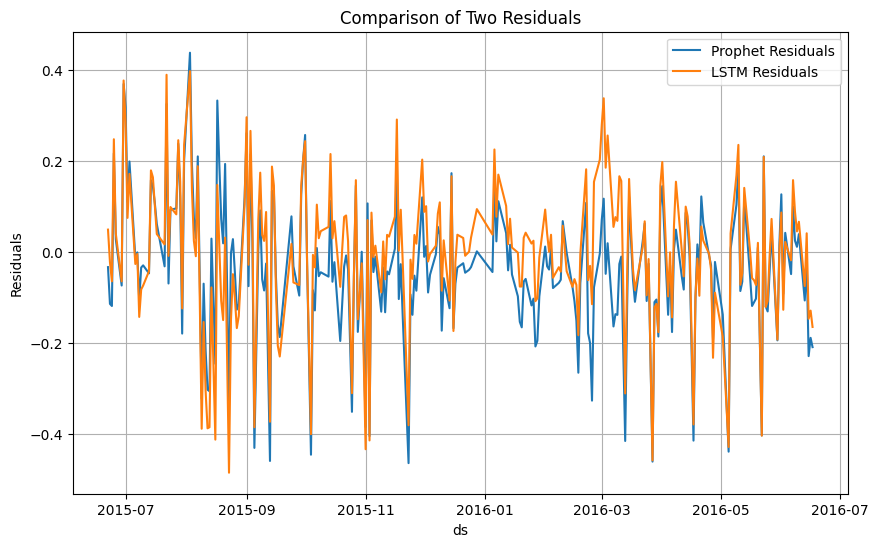

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results[category]['ds'], prophet_residuals[category], label='Prophet Residuals')
plt.plot(prophet_merged_results[category]['ds'], LSTM_residuals[category], label='LSTM Residuals')
plt.title('Comparison of Two Residuals')
plt.xlabel('ds')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
threshold = 0.1
prophet_count = 0
lstm_count = 0

# Iterate through Prophet residuals and count how many are closer to 0
for residual in prophet_residuals[category]:
    if abs(residual) <= threshold:
        prophet_count += 1

# Iterate through LSTM residuals and count how many are closer to 0
for residual in LSTM_residuals[category]:
    if abs(residual) <= threshold:
        lstm_count += 1

# Print the counts
print("Number of Prophet residuals closer to 0:", prophet_count)
print("Number of LSTM residuals closer to 0:", lstm_count)

Number of Prophet residuals closer to 0: 137
Number of LSTM residuals closer to 0: 153
